<a href="https://colab.research.google.com/github/MedAmine-SUDO/Tunisian-License-Plate-Recognition/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In case you got an error "Mask RCNN is not installed" you have to change directory to Mask_RCNN folder and run these commands:

1.   !pip install -r requirements.txt
2.   !python setup.py install



In [0]:
from os import listdir
import numpy as np
from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image
import cv2
import math
from scipy import ndimage
from keras.models import load_model

In [0]:
#Ensure that you are in the project directory
SUBMISSION_IMAGES = "./SubmissionImages/"

In [0]:
# define a configuration for the model
class LicensePlateConfig(Config):
	# define the name of the configuration
	NAME = "LicensePlate_cfg"
	# number of classes (background + License Plate)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [0]:
# prepare config
config = LicensePlateConfig()

In [0]:
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=config)

In [56]:
model.load_weights("./licenseplate_cfg20200509T2207/mask_rcnn_licenseplate_cfg_0031.h5", by_name=True)

Re-starting from epoch 31


In [0]:
#Detecting License Plate
image = pyplot.imread(SUBMISSION_IMAGES+"912.jpg")
# convert pixel values (e.g. center)
scaled_image = mold_image(image, config)
# convert image into one sample
sample = expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)[0]

In [0]:
def firstCrop(img, predictions):
    firstCrop = []
    for box in predictions['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        if width < height:
            continue
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        xtop = x1
        ytop = y1
        xbottom = x2
        ybottom = y2
        firstCrop.append(img[ytop:ybottom, xtop:xbottom])
        cv2.rectangle(img,(xtop,ytop),(xbottom,ybottom),(0,255,0),0)
    return firstCrop

In [0]:
l = firstCrop(image, yhat)

In [0]:
from google.colab.patches import cv2_imshow
import imutils

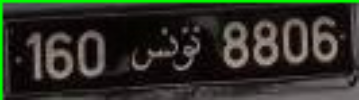

In [61]:
(h, w, d) = l[0].shape
ratio = w/h
img = cv2.resize(l[0], (int(100*ratio), 100))
(h, w, d) = img.shape
cv2_imshow(img)

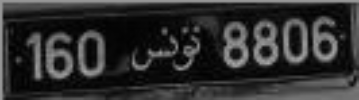

In [62]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

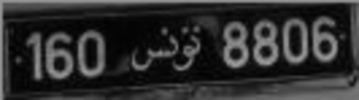

In [63]:
img = cv2.GaussianBlur(img, (3,3), 0)
cv2_imshow(img)

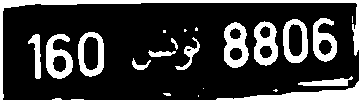

In [64]:
img2 = img.copy()
img2 = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]
cv2_imshow(img2)

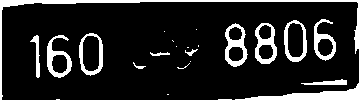

In [65]:
img2 = cv2.erode(img2, None, iterations=1)
cv2_imshow(img2)

In [0]:
DIGITS_PATH = './PlateDigits/'

198
47
30
79
255
225
284
314


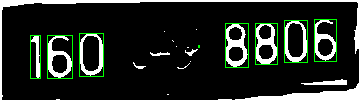

In [72]:
cnts = cv2.findContours(img2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []

img3 = img2.copy()
img3 = cv2.cvtColor(img3, cv2.COLOR_GRAY2BGR)
i=0

for c in cnts:
  (cx, cy, cw, ch) = cv2.boundingRect(c)
  #if ((cw >= w*0.05) and (cw <= w*0.5) and (ch >= h*0.5)):
  if ch >= 1.5*cw:
    digitCnts.append(c)
    i+=1
    cv2.rectangle(img3, (cx,cy), (cx+cw,cy+ch), (0,255,0), 1)
    cv2.imwrite(DIGITS_PATH+'chiffre'+str(cx)+'.jpg',img3[cy:cy+ch, cx:cx+cw])
cv2_imshow(img3)

In [0]:
MODEL_PATH = './model_02.h5'

In [0]:
from keras.models import load_model
rec_model = load_model(MODEL_PATH)

In [0]:
#img = cv2.imread(DIGITS_PATH+'chiffre30.jpg', 0)
gray = cv2.imread(DIGITS_PATH+'chiffre225.jpg', cv2.IMREAD_GRAYSCALE)

In [0]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [0]:
gray = cv2.resize(gray, (28, 28))  # 255-gray for inverting black and white
(thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
flatten = gray.flatten() / 255.0

while np.sum(gray[0]) == 0:
    gray = gray[1:]

while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)

while np.sum(gray[-1]) == 0:
    gray = gray[:-1]

while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)

rows,cols = gray.shape
if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    gray = cv2.resize(gray, (cols,rows))
else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    gray = cv2.resize(gray, (cols, rows))

colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

shiftx,shifty = getBestShift(gray)
shifted = shift(gray,shiftx,shifty)
gray = shifted

In [114]:
cv2_imshow(gray)

In [115]:
img = gray.reshape(1,1,28,28).astype('float32')
img = img / 255
prediction = rec_model.predict_classes(img)
print(prediction[0])

8
